[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/masadcv/FastGeodis/blob/master/samples/simpledemo3d.ipynb)

In [21]:
! pip install FastGeodis  wget SimpleITK -q

In [22]:
import os

import FastGeodis
import matplotlib.pyplot as plt
import numpy as np
import torch
import wget
import SimpleITK as sitk
from PIL import Image

In [23]:
# read images from local path or download from github repo (for colab)
image_path = "../data/img3d.nii.gz"

if not os.path.exists(os.path.dirname(image_path)):
    os.makedirs(os.path.dirname(image_path), exist_ok=True)

url = "https://raw.githubusercontent.com/masadcv/FastGeodis/master/data/"
wget.download(os.path.join(url, image_path), image_path) if not os.path.exists(image_path) else None

! ls ../data

brain.png	     brain_seg.png  img3d.nii.gz
brain_seg_noisy.png  img2d.png	    ISIC_546.jpg


# FastGeodis Method

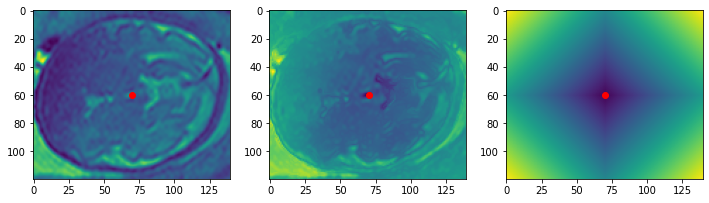

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

seed_pos = [10, 60, 70]
image_folder = os.path.dirname(image_path)
image_sitk = sitk.ReadImage(image_path)
image = sitk.GetArrayFromImage(image_sitk)
spacing_raw = image_sitk.GetSpacing()
spacing = [spacing_raw[2], spacing_raw[1], spacing_raw[0]]

image = np.asarray(image, np.float32)
image = image[18:38, 63:183, 93:233]
mask = np.zeros_like(image, np.uint8)
mask[seed_pos[0]][seed_pos[1]][seed_pos[2]] = 1

image_pt = torch.from_numpy(image).unsqueeze_(0).unsqueeze_(0)
mask_pt = (
    torch.from_numpy(1 - mask.astype(np.float32)).unsqueeze_(0).unsqueeze_(0)
)
image_pt = image_pt.to(device)
mask_pt = mask_pt.to(device)

v = 1e10
iterations = 2

lamb = 1.0  # <-- Geodesic distance transform
geodesic_dist = FastGeodis.signed_generalised_geodesic3d(
    image_pt, mask_pt, spacing, v, lamb, iterations
)
geodesic_dist = np.squeeze(geodesic_dist.cpu().numpy())

lamb = 0.0  # <-- Euclidean distance transform
euclidean_dist = FastGeodis.signed_generalised_geodesic3d(
    image_pt, mask_pt, spacing, v, lamb, iterations
)
euclidean_dist = np.squeeze(euclidean_dist.cpu().numpy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")


plt.subplot(1, 3, 2)
plt.imshow(geodesic_dist[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")

plt.subplot(1, 3, 3)
plt.imshow(euclidean_dist[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")

plt.show()

# Toivanen's Raster Method

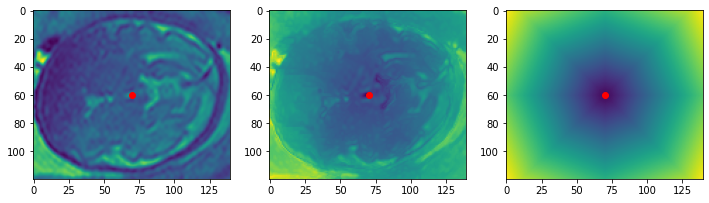

In [25]:
# Toivanen's method only support CPU
image_pt = image_pt.to("cpu")
mask_pt = mask_pt.to("cpu")

lamb = 1.0  # <-- Geodesic distance transform
geodesic_dist_toivanen = FastGeodis.signed_generalised_geodesic3d_toivanen(
    image_pt, mask_pt, spacing, v, lamb, iterations
)
geodesic_dist_toivanen = np.squeeze(geodesic_dist_toivanen.cpu().numpy())

lamb = 0.0  # <-- Euclidean distance transform
euclidean_dist_toivanen = FastGeodis.signed_generalised_geodesic3d_toivanen(
    image_pt, mask_pt, spacing, v, lamb, iterations
)
euclidean_dist_toivanen = np.squeeze(euclidean_dist_toivanen.cpu().numpy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")

plt.subplot(1, 3, 2)
plt.imshow(geodesic_dist_toivanen[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")

plt.subplot(1, 3, 3)
plt.imshow(euclidean_dist_toivanen[10])
plt.plot(seed_pos[2], seed_pos[1], "ro")

plt.show()